In [1]:
import cv2 as cv
import numpy as np
import os
from skimage import io
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pickle

In [2]:
#downsampling every nth frame
n = 7

flow_train=[]
flow_test=[]
y_test=[]
y_train=[]

path = os.path.join(os.getcwd(),'videos')
for folder in ['handclapping','handwaving','running']:
    current_folder = os.path.join(path,folder)
    for sample in tqdm(os.listdir(current_folder)):
        video_flow=[]
        sample_dir = os.path.join(current_folder,sample)
        cap = cv.VideoCapture(sample_dir)
        
        ret, first_frame = cap.read()
        prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
        test_flag = False
        if random.uniform(0, 1)<0.2:
            test_flag = True
        # Sets image saturation to maximum
 
  
        i=0
        to_second=18
        thresh = 25*to_second
        while(cap.isOpened() and ret and i<thresh):
            i+=1
            ret, frame = cap.read()
            if ret == True:
                
                if i%n == 0:

                    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
                    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                           None,
                                           0.5, 3, 15, 3, 5, 1.2, 0)

                    # Computes the magnitude and angle of the 2D vectors
                    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
                    angle = cv.resize(angle,(0, 0),fx=0.5, fy=0.5, interpolation = cv.INTER_AREA)
                    video_flow.append(angle.flatten())
                    prev_gray = gray
        
        if test_flag:
            flow_test.append(np.array(video_flow))
            if folder == 'handclapping':
                y_test.append(-1)
            elif folder == 'handwaving':
                y_test.append(0)
            else:
                y_test.append(1)
        else:
            flow_train.append(np.array(video_flow))
            if folder == 'handclapping':
                y_train.append(-1)
            elif folder == 'handwaving':
                y_train.append(0)
            else:
                y_train.append(1)
                
        cap.release()
        cv.destroyAllWindows()
       
            



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


In [8]:
import pickle
frame_train = np.concatenate(flow_train,axis=0)

for n_cluster in tqdm([180,200,220]): 


    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(frame_train)

    filename = 'cluster_'+str(n_cluster)+".pickle"

    # save model
    pickle.dump(kmeans, open(filename, "wb"))



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [23:53<00:00, 477.69s/it]


In [6]:
def train_SVM(flow_train,flow_test,y_train,y_test,kmeans,n_clusters):
    X_train = []
    X_test = []
    for video in flow_train:
        video_feature = np.histogram(kmeans.predict(video), bins=range(n_clusters+1))[0]
        X_train.append(video_feature)
    for video in flow_test:
        video_feature = np.histogram(kmeans.predict(video), bins=range(n_clusters+1))[0]
        X_test.append(video_feature)
    
    
    
    
    print('------------------------------ RBF ------------------------------\n')
    C_range = np.logspace(-15, 10, 20)
    gamma_range = np.logspace(-10, 10, 20)

    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(kernel = 'rbf', class_weight='balanced', decision_function_shape='ovr'), param_grid=param_grid, cv=cv)
    grid.fit(X_train, y_train)


    print(
        "The best parameters are %s with a score of %0.2f\n"
        % (grid.best_params_, grid.best_score_)
    )


    clf_rbf = SVC(C =grid.best_params_['C'],gamma =grid.best_params_['gamma'], kernel='rbf', class_weight='balanced', decision_function_shape='ovr')
    clf_rbf.fit(X_train,y_train)
    y_pred = clf_rbf.predict(X_test)

    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_estimator(
        clf_rbf, X_test, y_test, display_labels=['clapping','waving','running'], xticks_rotation="vertical"
    )
    plt.tight_layout()
    plt.show()

    #---------------------------------------------------------------------------------------------------------------
    
    print('------------------------------ Linear ------------------------------\n')
    C_range = np.logspace(-15, 10, 20)
    gamma_range = np.logspace(-6, 3, 4)

    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(kernel = 'linear', class_weight='balanced', decision_function_shape='ovr'), param_grid=param_grid, cv=cv)
    grid.fit(X_train, y_train)


    print(
        "The best parameters are %s with a score of %0.2f\n"
        % (grid.best_params_, grid.best_score_)
    )


    clf_lin = SVC(C =grid.best_params_['C'],gamma =grid.best_params_['gamma'], kernel='linear', class_weight='balanced', decision_function_shape='ovr')
    clf_lin.fit(X_train,y_train)
    y_pred = clf_lin.predict(X_test)

    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_estimator(
        clf_lin, X_test, y_test, display_labels=['clapping','waving','running'], xticks_rotation="vertical"
    )
    plt.tight_layout()
    plt.show()
    
    #---------------------------------------------------------------------------------------------------------------

    print('------------------------------ Sigmoid ------------------------------\n')
    C_range = np.logspace(-15, 10, 20)
    gamma_range = np.logspace(-6, 3, 4)
    coef0_range = np.logspace(-6, 3, 4)

    param_grid = dict(coef0=coef0_range, gamma=gamma_range, C=C_range)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(kernel = 'sigmoid', class_weight='balanced', decision_function_shape='ovr'), param_grid=param_grid, cv=cv)
    grid.fit(X_train, y_train)


    print(
        "The best parameters are %s with a score of %0.2f\n"
        % (grid.best_params_, grid.best_score_)
    )


    clf_sig = SVC(C =grid.best_params_['C'],gamma =grid.best_params_['gamma'],coef0 =grid.best_params_['coef0'], kernel='sigmoid', class_weight='balanced', decision_function_shape='ovr')
    clf_sig.fit(X_train,y_train)
    y_pred = clf_sig.predict(X_test)

    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_estimator(
        clf_sig, X_test, y_test, display_labels=['clapping','waving','running'], xticks_rotation="vertical"
    )
    plt.tight_layout()
    plt.show()
    
    return [clf_rbf,clf_lin,clf_sig]

# 180 Clusters

In [3]:
# load model
filename = "cluster_180.pickle"
n_clusters = 180
kmeans_180 = pickle.load(open(filename, "rb"))


## train set 180 clusters

------------------------------ RBF ------------------------------

The best parameters are {'C': 54555.947811685146, 'gamma': 1.438449888287663e-07} with a score of 0.87

              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        78
           0       1.00      0.95      0.98        83
           1       1.00      1.00      1.00        83

    accuracy                           0.98       244
   macro avg       0.98      0.98      0.98       244
weighted avg       0.98      0.98      0.98       244



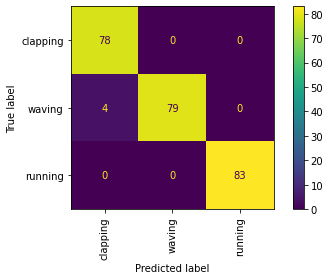

------------------------------ Linear ------------------------------

The best parameters are {'C': 0.01438449888287666, 'gamma': 1e-06} with a score of 0.87

              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        78
           0       1.00      0.95      0.98        83
           1       1.00      1.00      1.00        83

    accuracy                           0.98       244
   macro avg       0.98      0.98      0.98       244
weighted avg       0.98      0.98      0.98       244



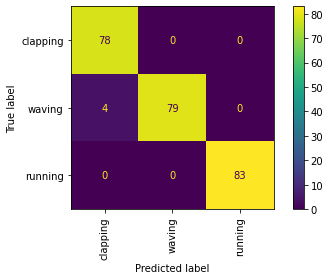

------------------------------ Sigmoid ------------------------------

The best parameters are {'C': 6.158482110660279, 'coef0': 1e-06, 'gamma': 0.001} with a score of 0.85

              precision    recall  f1-score   support

          -1       0.94      0.96      0.95        78
           0       0.97      0.92      0.94        83
           1       0.95      0.99      0.97        83

    accuracy                           0.95       244
   macro avg       0.96      0.96      0.95       244
weighted avg       0.96      0.95      0.95       244



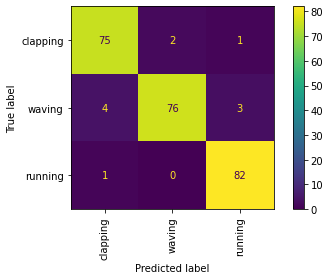

In [9]:
[_,_,_] = train_SVM(flow_train,flow_train,y_train,y_train,kmeans_180,n_clusters)

## test set 180 clusters

------------------------------ RBF ------------------------------

The best parameters are {'C': 54555.947811685146, 'gamma': 1.438449888287663e-07} with a score of 0.87

              precision    recall  f1-score   support

          -1       0.90      0.86      0.88        21
           0       0.84      0.94      0.89        17
           1       1.00      0.94      0.97        17

    accuracy                           0.91        55
   macro avg       0.91      0.91      0.91        55
weighted avg       0.91      0.91      0.91        55



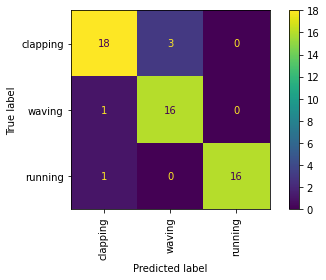

------------------------------ Linear ------------------------------

The best parameters are {'C': 0.01438449888287666, 'gamma': 1e-06} with a score of 0.87

              precision    recall  f1-score   support

          -1       0.90      0.86      0.88        21
           0       0.84      0.94      0.89        17
           1       1.00      0.94      0.97        17

    accuracy                           0.91        55
   macro avg       0.91      0.91      0.91        55
weighted avg       0.91      0.91      0.91        55



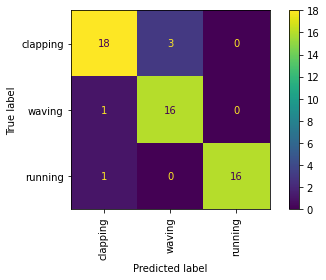

------------------------------ Sigmoid ------------------------------

The best parameters are {'C': 6.158482110660279, 'coef0': 1e-06, 'gamma': 0.001} with a score of 0.85

              precision    recall  f1-score   support

          -1       0.94      0.81      0.87        21
           0       0.80      0.94      0.86        17
           1       1.00      1.00      1.00        17

    accuracy                           0.91        55
   macro avg       0.91      0.92      0.91        55
weighted avg       0.92      0.91      0.91        55



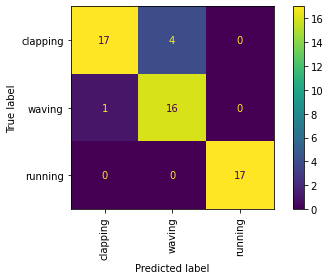

In [10]:
[clf_rbf180,clf_lin180,clf_sig180] = train_SVM(flow_train,flow_test,y_train,y_test,kmeans_180,n_clusters)

# 200 Clusters

In [4]:
# load model
filename = "cluster_200.pickle"
n_clusters = 200
kmeans_200 = pickle.load(open(filename, "rb"))

## train set 200 clusters

------------------------------ RBF ------------------------------

The best parameters are {'C': 6.158482110660279, 'gamma': 0.002335721469090121} with a score of 0.83

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        78
           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        83

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



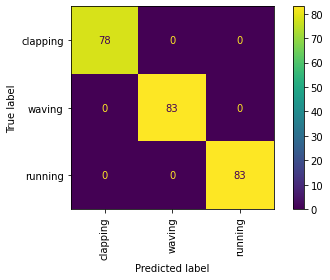

------------------------------ Linear ------------------------------

The best parameters are {'C': 0.01438449888287666, 'gamma': 1e-06} with a score of 0.83

              precision    recall  f1-score   support

          -1       0.96      0.99      0.97        78
           0       0.99      0.96      0.98        83
           1       0.99      0.99      0.99        83

    accuracy                           0.98       244
   macro avg       0.98      0.98      0.98       244
weighted avg       0.98      0.98      0.98       244



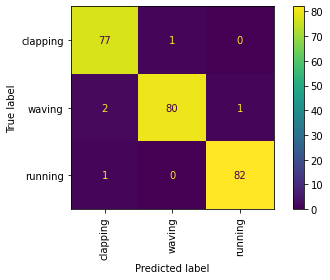

------------------------------ Sigmoid ------------------------------

The best parameters are {'C': 1128837.891684693, 'coef0': 1.0, 'gamma': 1e-06} with a score of 0.83

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        78
           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        83

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



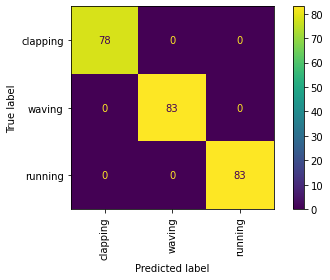

In [12]:
[_,_,_] = train_SVM(flow_train,flow_train,y_train,y_train,kmeans_200,n_clusters)

## test set 200 clusters

------------------------------ RBF ------------------------------

The best parameters are {'C': 6.158482110660279, 'gamma': 0.002335721469090121} with a score of 0.83

              precision    recall  f1-score   support

          -1       0.89      0.76      0.82        21
           0       0.75      0.88      0.81        17
           1       1.00      1.00      1.00        17

    accuracy                           0.87        55
   macro avg       0.88      0.88      0.88        55
weighted avg       0.88      0.87      0.87        55



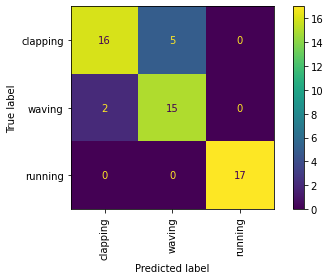

------------------------------ Linear ------------------------------

The best parameters are {'C': 0.01438449888287666, 'gamma': 1e-06} with a score of 0.83

              precision    recall  f1-score   support

          -1       0.90      0.86      0.88        21
           0       0.83      0.88      0.86        17
           1       1.00      1.00      1.00        17

    accuracy                           0.91        55
   macro avg       0.91      0.91      0.91        55
weighted avg       0.91      0.91      0.91        55



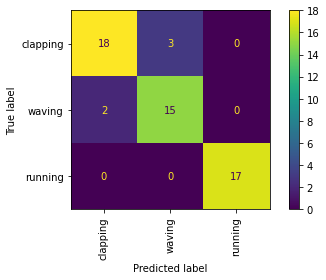

------------------------------ Sigmoid ------------------------------

The best parameters are {'C': 1128837.891684693, 'coef0': 1.0, 'gamma': 1e-06} with a score of 0.83

              precision    recall  f1-score   support

          -1       0.94      0.81      0.87        21
           0       0.83      0.88      0.86        17
           1       0.89      1.00      0.94        17

    accuracy                           0.89        55
   macro avg       0.89      0.90      0.89        55
weighted avg       0.89      0.89      0.89        55



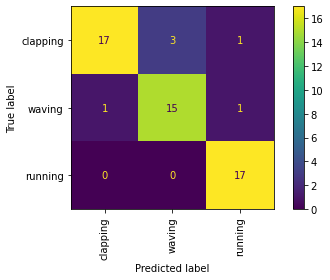

In [13]:
[clf_rbf200,clf_lin200,clf_sig200] = train_SVM(flow_train,flow_test,y_train,y_test,kmeans_200,n_clusters)

# 220 Clusters

In [5]:
# load model
filename = "cluster_220.pickle"
n_clusters = 220
kmeans_220 = pickle.load(open(filename, "rb"))

## train set 220 clusters

------------------------------ RBF ------------------------------

The best parameters are {'C': 127.42749857031426, 'gamma': 0.002335721469090121} with a score of 0.84

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        78
           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        83

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



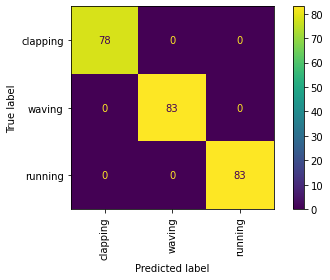

------------------------------ Linear ------------------------------

The best parameters are {'C': 0.2976351441631325, 'gamma': 1e-06} with a score of 0.82

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        78
           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        83

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



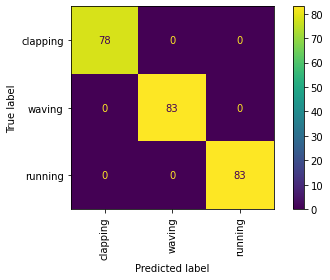

------------------------------ Sigmoid ------------------------------

The best parameters are {'C': 6.158482110660279, 'coef0': 1e-06, 'gamma': 0.001} with a score of 0.82

              precision    recall  f1-score   support

          -1       0.92      0.86      0.89        78
           0       0.93      0.90      0.91        83
           1       0.92      1.00      0.96        83

    accuracy                           0.92       244
   macro avg       0.92      0.92      0.92       244
weighted avg       0.92      0.92      0.92       244



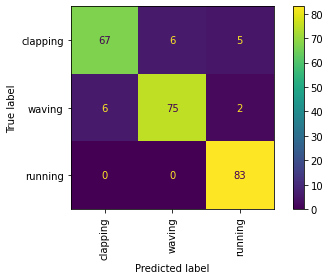

In [16]:
[_,_,_] = train_SVM(flow_train,flow_train,y_train,y_train,kmeans_220,n_clusters)

## test set 220 clusters

------------------------------ RBF ------------------------------

The best parameters are {'C': 127.42749857031426, 'gamma': 0.002335721469090121} with a score of 0.84

              precision    recall  f1-score   support

          -1       1.00      0.81      0.89        21
           0       0.85      1.00      0.92        17
           1       0.94      1.00      0.97        17

    accuracy                           0.93        55
   macro avg       0.93      0.94      0.93        55
weighted avg       0.94      0.93      0.93        55



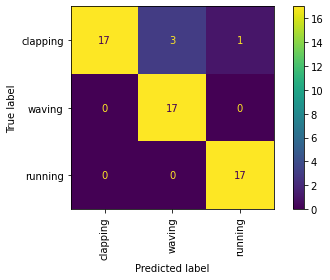

------------------------------ Linear ------------------------------

The best parameters are {'C': 0.2976351441631325, 'gamma': 1e-06} with a score of 0.82

              precision    recall  f1-score   support

          -1       0.94      0.81      0.87        21
           0       0.84      0.94      0.89        17
           1       0.94      1.00      0.97        17

    accuracy                           0.91        55
   macro avg       0.91      0.92      0.91        55
weighted avg       0.91      0.91      0.91        55



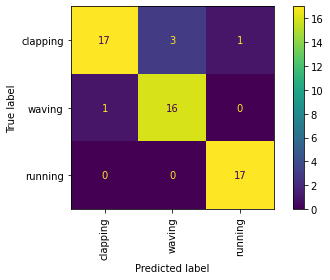

------------------------------ Sigmoid ------------------------------

The best parameters are {'C': 6.158482110660279, 'coef0': 1e-06, 'gamma': 0.001} with a score of 0.82

              precision    recall  f1-score   support

          -1       0.94      0.76      0.84        21
           0       0.75      0.88      0.81        17
           1       0.94      1.00      0.97        17

    accuracy                           0.87        55
   macro avg       0.88      0.88      0.87        55
weighted avg       0.88      0.87      0.87        55



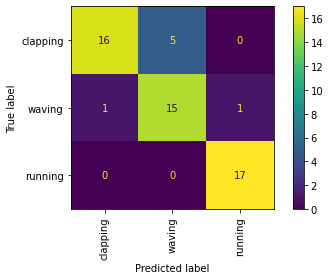

In [18]:
[clf_rbf220,clf_lin220,clf_sig220] = train_SVM(flow_train,flow_test,y_train,y_test,kmeans_220,n_clusters)

# Online Test

In [6]:
best_kmeans = kmeans_220 

n_clusters = 220

flow_train_final = flow_train.copy()
flow_train_final.extend(flow_test)
y_train_final = y_train.copy()
y_train_final.extend(y_test)

X_train_final=[]
for video in flow_train_final:
        video_feature = np.histogram(best_kmeans.predict(video), bins=range(n_clusters+1))[0]
        X_train_final.append(video_feature)
        
best_clf = SVC(C =127.42749857031426,gamma =0.002335721469090121, kernel='rbf', class_weight='balanced', decision_function_shape='ovr')
best_clf.fit(X_train_final,y_train_final)

SVC(C=127.42749857031426, class_weight='balanced', gamma=0.002335721469090121)

In [8]:
def print_label(y_pred, image):
    if y_pred == -1:
        action = 'Clapping'
    elif y_pred == 0:
        action = 'Waving'
    else:
        action = 'Running'
    font = cv.FONT_HERSHEY_SIMPLEX

    # org
    org = (5, 40)

    # fontScale
    fontScale = 1

    # Blue color in BGR
    color = (0, 0,255)

    # Line thickness of 2 px
    thickness = 4

    # Using cv2.putText() method
    labeled_image = cv.putText(image, action, org, font, 
                       fontScale, color, thickness, cv.LINE_AA)
    return labeled_image

In [11]:

import cv2 as cv


#--------------------------------
path = 'person22_handwaving_d3_uncomp.avi'
cap = cv.VideoCapture(0)


ret, first_frame = cap.read()
first_frame = cv.resize(first_frame,(80, 60),interpolation = cv.INTER_AREA)

prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

# Creates an image filled with zero
# intensities with the same dimensions 
# as the frame
mask = np.zeros_like(first_frame)
  
# Sets image saturation to maximum
mask[..., 1] = 255
video_flow = []
i = 0
n=3
while(cap.isOpened()):
      
    ret, big_frame = cap.read()
    i+=1
    # Opens a new window and displays the input
    # frame
    if i%n ==0:
        
        frame = cv.resize(big_frame,(80, 60),interpolation = cv.INTER_AREA)
    # Converts each frame to grayscale - we previously 
    # only converted the first frame to grayscale
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
      
    # Calculates dense optical flow by Farneback method
        flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 30, 3, 5, 1.2, 0)
      
    # Computes the magnitude and angle of the 2D vectors
        magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    # Sets image hue according to the optical flow 
    # direction
        mask[..., 0] = angle * 180 / np.pi / 2
      
    # Sets image value according to the optical flow
    # magnitude (normalized)
        mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
      
    # Converts HSV to RGB (BGR) color representation
        rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
      
    # Opens a new window and displays the output frame
        #cv.imshow("dense optical flow", rgb)
        
        
        #angle = cv.resize(angle,(80, 60),interpolation = cv.INTER_AREA)
        video_flow.append(angle.flatten())
        if len(video_flow)>40:
            video_flow.pop(0)
        video_feature = np.histogram(best_kmeans.predict(np.array(video_flow)), bins=range(n_clusters+1))[0]
        pred = best_clf.predict([video_feature])
        
        cv.imshow("input", print_label(pred, big_frame))
    # Updates previous frame
        prev_gray = gray
      
    # Frames are read by intervals of 1 millisecond. The
    # programs breaks out of the while loop when the
    # user presses the 'q' key
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
  
# closes all windows
cap.release()
cv.destroyAllWindows()